In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

In [3]:
storage = os.environ['MICOM_EXP'] + 'test_RKTolerance/' # on Peregrine
print(storage)

run_status_file = storage + "run_status.tsv"
run_status = pd.read_csv(run_status_file, sep="\t", usecols=['communityID','case', 'culture_type', 'program_log_doneSim'])

case_communityID_dict = run_status.loc[run_status['program_log_doneSim']==1.0, :].groupby(['case', 'culture_type'])['communityID'].apply(list).to_dict()
case_communityID_dict

/data/s4278836/First_project/experiments/test_RKTolerance/


{('RKTo4', 'batch'): ['I_a_I_b', 'II_b_III_b', 'III_b_IV_a'],
 ('RKTo4', 'continuous'): ['I_a_I_b', 'II_b_III_b', 'III_b_IV_a'],
 ('RKTo5', 'batch'): ['I_a_I_b', 'II_b_III_b', 'III_b_IV_a'],
 ('RKTo5', 'continuous'): ['I_a_I_b', 'II_b_III_b', 'III_b_IV_a'],
 ('RKTo6', 'batch'): ['I_a_I_b', 'II_b_III_b', 'III_b_IV_a'],
 ('RKTo6', 'continuous'): ['I_a_I_b', 'II_b_III_b', 'III_b_IV_a'],
 ('RKTo6a', 'continuous'): ['III_b_IV_a']}

In [4]:
case_communityID_check_dict = {x[0]+'_'+x[1]: {case_communityID_dict[x][i]: 1 for i in range(len(case_communityID_dict[x]))} for x in case_communityID_dict.keys()}
case_communityID_df = pd.DataFrame.from_dict(case_communityID_check_dict, dtype='float')

case_communityID_df

RKTo4_batch  RKTo4_continuous  RKTo5_batch  RKTo5_continuous  \
I_a_I_b             1.0               1.0          1.0               1.0   
II_b_III_b          1.0               1.0          1.0               1.0   
III_b_IV_a          1.0               1.0          1.0               1.0   

            RKTo6_batch  RKTo6_continuous  RKTo6a_continuous  
I_a_I_b             1.0               1.0                NaN  
II_b_III_b          1.0               1.0                NaN  
III_b_IV_a          1.0               1.0                1.0

In [5]:
communityID_list = list(case_communityID_df.index.values)
print(communityID_list)

batch_case_list = list({x for x in case_communityID_df.columns if x.rsplit("_")[1] == 'batch'})
batch_case_list.sort()
print(batch_case_list)

cont_case_list = list({x for x in case_communityID_df.columns if x.rsplit("_")[1] == 'continuous'})
cont_case_list.sort()
print(cont_case_list)

media = ['EU_avg', 'DACH', 'diabetes2', 
         'gluten_free', 'high_fat', 'high_fiber', 
         'high_protein', 'mediterranean', 'unhealthy', 
         'vegan', 'vegetarian']

['I_a_I_b', 'II_b_III_b', 'III_b_IV_a']
['RKTo4_batch', 'RKTo5_batch', 'RKTo6_batch']
['RKTo4_continuous', 'RKTo5_continuous', 'RKTo6_continuous', 'RKTo6a_continuous']


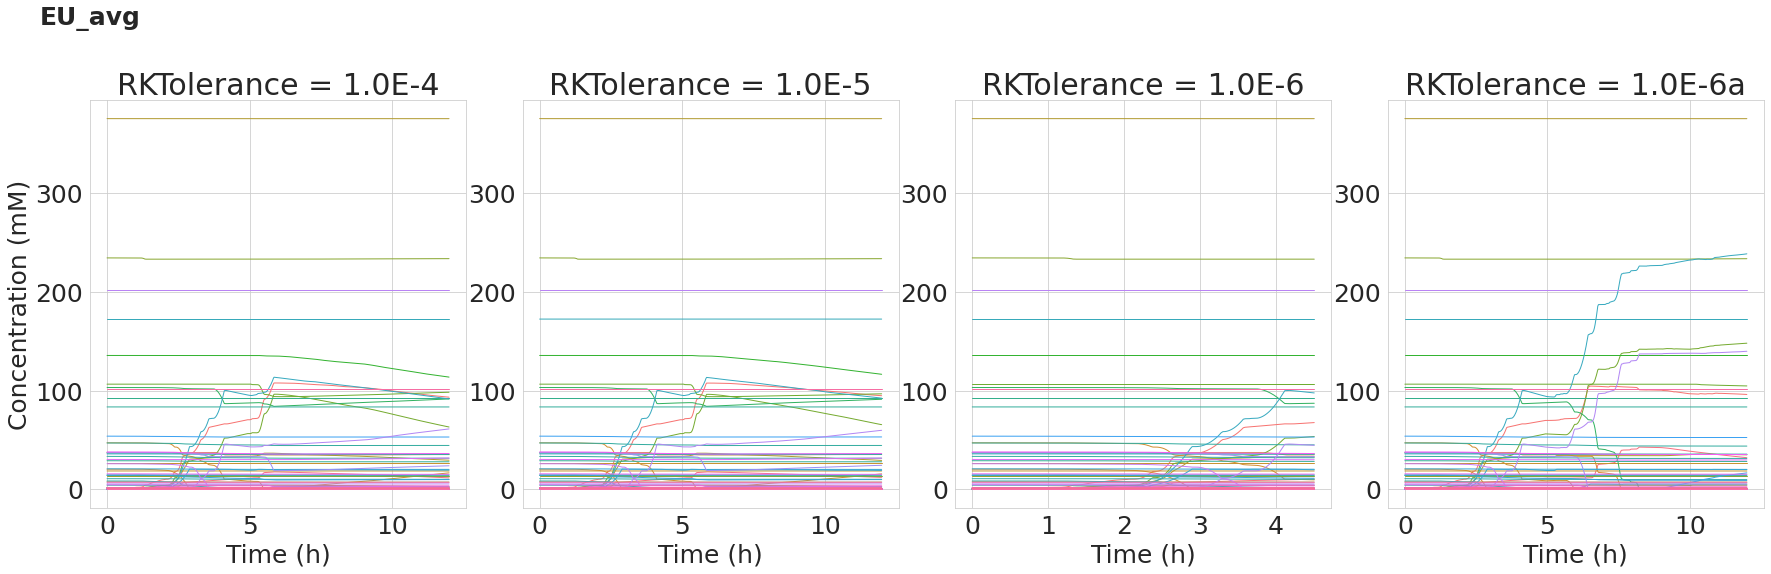

In [6]:
communityID = 'III_b_IV_a'
cases = cont_case_list
media = ['EU_avg']

check_culture_type = set(c.rsplit('_')[1] for c in cases)

if len(check_culture_type) > 1:
    raise ValueError('Function only works for one type of culture, either batch or continuous')

# Simulation ID = community ID in PLASTIC mode
simID = communityID + '_plastic'

# Figure object & outer layer
fig = plt.figure(figsize=(7.5*len(cases), 7.5*len(media)))

outer = gridspec.GridSpec(nrows=len(media), ncols=1, wspace=0.2, hspace=0.2)

# Create data frame & plot for each media:
for i in range(len(media)):
    m = media[i]
    avail_cases = [] # list of cases having data for the targeted media
    
    # Prepare dataframe
    merged_data = pd.DataFrame()
    
    for c in cases:
        case = c.rsplit('_')[0]
        
        data_dir = storage + '/v2.10.0_sim_' + simID + '.' + case + '/experiments/' + list(check_culture_type)[0] + '_coculture/'  + m + '/'
        data_file = data_dir + 'metabolites_trajectory.tsv'

        if os.path.isfile(data_file):

            df = pd.read_csv(data_file, sep="\t")
            metabolites = df.columns[1:]

            case_label = '1.0E-' + case.replace('RKTo','')
            df['RKTolerance'] = case_label
            avail_cases.append(case_label)

            merged_data = pd.concat([merged_data, df])

        else:
            mess = ['There is no output for simulation in', m, '+', list(check_culture_type)[0], 'culture for case', case]
            warnings.warn(" ".join(mess))
    
    unchanged_metabolites = list(metabolites[merged_data[metabolites].sum() == 0.0])
    metabolites = list(metabolites[merged_data[metabolites].sum() != 0.0])
    
    merged_data.drop(labels = unchanged_metabolites, axis=1, inplace=True)
    
    # Plotting
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=len(avail_cases),
                                             subplot_spec=outer[i], wspace=0.15, hspace=0.15)

    for j in range(len(avail_cases)):

        plot_data = merged_data.loc[merged_data['RKTolerance'] == avail_cases[j], :]
        plot_data = pd.melt(plot_data, id_vars='time', value_vars=metabolites, var_name = 'metabolite', value_name='concentration')

        plot_ax = plt.Subplot(fig, inner[j])

        kwargs={'linewidth':1}
        g = sns.lineplot(data = plot_data, x='time', y='concentration', hue='metabolite', ax=plot_ax, legend=False,
                         **kwargs)
        title = 'RKTolerance = ' + avail_cases[j]
        plot_ax.set(title=title, xlabel='Time (h)')
        
        if j == 0:
            plot_ax.text(0.0, 1.2, s=media[i], ha='center', va='center', transform=plot_ax.transAxes, 
                         fontweight='bold')
            plot_ax.set(ylabel='Concentration (mM)')
        else:
            plot_ax.set(ylabel='')

        fig.add_subplot(plot_ax)